# Prediksi Berdasarkan Genotipe Induk (Tanpa OffspringPhenotype)

Notebook ini mengimplementasikan berbagai algoritma machine learning untuk memprediksi hasil persilangan berdasarkan informasi genotipe induk untuk organisme flora dan fauna. Kolom OffspringPhenotype telah dihapus dari seluruh proses, fitur, dan penjelasan.

In [1]:
# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn ipywidgets

In [2]:
# Import semua libraries yang diperlukan dalam notebook ini
# Disusun berdasarkan kategori untuk kemudahan pemahaman

# ===== LIBRARIES DASAR =====
# Libraries untuk manipulasi data dan operasi numerik
import pandas as pd
import numpy as np

# ===== LIBRARIES VISUALISASI =====
# Libraries untuk visualisasi data dan hasil model
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle  # Untuk membuat siklus warna dalam plot

# ===== LIBRARIES PREPROCESSING =====
# Libraries untuk preprocessing data
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif

# ===== LIBRARIES MODEL MACHINE LEARNING =====
# Decision Tree
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Naive Bayes
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Regression models
from sklearn.linear_model import LinearRegression

# Tambahan model yang mungkin digunakan untuk perbandingan
from sklearn.neighbors import KNeighborsClassifier

# ===== LIBRARIES EVALUASI MODEL =====
# Libraries untuk mengevaluasi performa model
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    balanced_accuracy_score, f1_score, roc_auc_score,
    roc_curve, auc, mean_squared_error, r2_score, mean_absolute_error
)

# ===== LIBRARIES UNTUK HANDLING DATA TIDAK SEIMBANG =====
from imblearn.over_sampling import SMOTE

# ===== LIBRARIES UNTUK VISUALISASI INTERAKTIF =====
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# ===== PENGATURAN UMUM =====
# Suppress warnings untuk membersihkan output
import warnings
warnings.filterwarnings('ignore')

# Set style untuk plotting
plt.style.use('default')
sns.set_palette("viridis")

print("Libraries berhasil diimport!")

Libraries berhasil diimport!


## 1. Data Loading dan Eksplorasi

In [3]:
# DATA LOADING DAN EKPLORASI (Tanpa OffspringPhenotype)

# Dataset ini berisi informasi genetik organisme flora dan fauna
# Kita akan menganalisis informasi genotipe induk

df = pd.read_csv('combined_genetics_dataset.csv')

# Tampilkan dimensi dataset
print(f"Jumlah baris dan kolom: {df.shape}")

# Tampilkan sampel data
print("\nSampel 5 baris pertama:")
print(df.head(5))

# Periksa nilai null dalam dataset
print("\nPengecekan nilai yang hilang (null):")
print(df.isnull().sum())

# Statistik deskriptif dasar
print("\nStatistik deskriptif:")
print(df.describe(include='all').T)  # Transpose untuk tampilan yang lebih baik

# Distribusi tipe organisme
print("\nDistribusi OrganismType:")
organism_dist = df['OrganismType'].value_counts()
print(organism_dist)
print(f"\nPersentase distribusi organisme:")
for org_type, count in organism_dist.items():
    print(f"- {org_type}: {count/len(df):.2%}")

Jumlah baris dan kolom: (50000, 6)

Sampel 5 baris pertama:
  OrganismType Parent1Genotype Parent1Gamete Parent2Genotype Parent2Gamete  \
0        Flora            AABB            ab              aa             a   
1        Flora            aaBB            aB            aaBB            aB   
2        Fauna            EEtt            Et            EeTT            ET   
3        Fauna            EeTt            et            EETt            ET   
4        Flora              AA             A            AAbb            Ab   

  OffspringPhenotype  
0     White Wrinkled  
1        White Round  
2    TailShort,Brown  
3    TailShort,Brown  
4    Purple Wrinkled  

Pengecekan nilai yang hilang (null):
OrganismType          0
Parent1Genotype       0
Parent1Gamete         0
Parent2Genotype       0
Parent2Gamete         0
OffspringPhenotype    0
dtype: int64

Statistik deskriptif:
                    count unique              top   freq
OrganismType        50000      2            Fauna  25012
P

## 2. Feature Engineering dan Preprocessing

In [4]:
# Feature Engineering dan Preprocessing Data (Tanpa OffspringPhenotype)
def preprocess_data(df):
    """
    Melakukan preprocessing data untuk model machine learning:
    1. Ekstraksi fitur dari genotipe induk untuk mendapatkan informasi tentang alel
    2. Encoding kategorikal untuk fitur menggunakan LabelEncoder
    3. Transformasi data untuk format yang sesuai dengan model ML
    4. Membuat OffspringGenotype dari kombinasi gamet induk

    Args:
        df: DataFrame asli yang berisi data genetik

    Returns:
        df_processed: DataFrame setelah preprocessing
        le_dict: Dictionary berisi encoder untuk setiap kolom kategorikal
    """
    df_processed = df.copy()

    # ===== MEMBUAT OFFSPRING GENOTYPE DARI KOMBINASI GAMET =====
    def create_offspring_genotype(row):
        """Membuat genotipe keturunan dari kombinasi gamet kedua induk"""
        parent1_gamete = row['Parent1Gamete']
        parent2_gamete = row['Parent2Gamete']
        organism_type = row['OrganismType']
        
        if organism_type == 'Flora':
            # Untuk Flora - satu atau dua sifat (A/a, B/b)
            if len(parent1_gamete) == 1 and len(parent2_gamete) == 1:
                # Satu sifat saja
                return ''.join(sorted([parent1_gamete, parent2_gamete]))
            elif len(parent1_gamete) == 2 and len(parent2_gamete) == 2:
                # Dua sifat
                first_trait = ''.join(sorted([parent1_gamete[0], parent2_gamete[0]]))
                second_trait = ''.join(sorted([parent1_gamete[1], parent2_gamete[1]]))
                return first_trait + second_trait
        else:  # Fauna
            # Untuk Fauna - selalu dua sifat (E/e, T/t)
            if len(parent1_gamete) == 2 and len(parent2_gamete) == 2:
                first_trait = ''.join(sorted([parent1_gamete[0], parent2_gamete[0]]))
                second_trait = ''.join(sorted([parent1_gamete[1], parent2_gamete[1]]))
                return first_trait + second_trait
        
        return 'Unknown'

    # Tambahkan kolom OffspringGenotype
    df_processed['OffspringGenotype'] = df_processed.apply(create_offspring_genotype, axis=1)

    # ===== EKSTRAKSI FITUR GENETIK =====
    df_processed['P1_Has_A'] = df_processed.apply(
        lambda row: 'A' in row['Parent1Genotype'] if row['OrganismType'] == 'Flora' else False,
        axis=1
    )
    df_processed['P1_Has_B'] = df_processed.apply(
        lambda row: 'B' in row['Parent1Genotype'] if row['OrganismType'] == 'Flora' else False,
        axis=1
    )
    df_processed['P1_Has_E'] = df_processed.apply(
        lambda row: 'E' in row['Parent1Genotype'] if row['OrganismType'] == 'Fauna' else False,
        axis=1
    )
    df_processed['P1_Has_T'] = df_processed.apply(
        lambda row: 'T' in row['Parent1Genotype'] if row['OrganismType'] == 'Fauna' else False,
        axis=1
    )
    df_processed['P2_Has_A'] = df_processed.apply(
        lambda row: 'A' in row['Parent2Genotype'] if row['OrganismType'] == 'Flora' else False,
        axis=1
    )
    df_processed['P2_Has_B'] = df_processed.apply(
        lambda row: 'B' in row['Parent2Genotype'] if row['OrganismType'] == 'Flora' else False,
        axis=1
    )
    df_processed['P2_Has_E'] = df_processed.apply(
        lambda row: 'E' in row['Parent2Genotype'] if row['OrganismType'] == 'Fauna' else False,
        axis=1
    )
    df_processed['P2_Has_T'] = df_processed.apply(
        lambda row: 'T' in row['Parent2Genotype'] if row['OrganismType'] == 'Fauna' else False,
        axis=1
    )

    # ===== LABEL ENCODING UNTUK FITUR KATEGORIKAL =====
    le_dict = {}
    categorical_cols = ['OrganismType', 'Parent1Genotype', 'Parent1Gamete',
                        'Parent2Genotype', 'Parent2Gamete', 'OffspringGenotype']
    for col in categorical_cols:
        le = LabelEncoder()
        df_processed[col + '_encoded'] = le.fit_transform(df_processed[col])
        le_dict[col] = le

    return df_processed, le_dict

# Jalankan preprocessing data
df_processed, label_encoders = preprocess_data(df)

# Tampilkan hasil preprocessing
print("Data setelah preprocessing:")
print(df_processed.head())
print("\nFitur yang dihasilkan setelah preprocessing:")
print(df_processed.columns.tolist())

# Menampilkan informasi tentang encoding untuk beberapa fitur penting lainnya
print("\nMapping OrganismType:")
organism_classes = list(label_encoders['OrganismType'].classes_)
organism_encoded = list(range(len(organism_classes)))
print(pd.DataFrame({'Original': organism_classes, 'Encoded': organism_encoded}))

Data setelah preprocessing:
  OrganismType Parent1Genotype Parent1Gamete Parent2Genotype Parent2Gamete  \
0        Flora            AABB            ab              aa             a   
1        Flora            aaBB            aB            aaBB            aB   
2        Fauna            EEtt            Et            EeTT            ET   
3        Fauna            EeTt            et            EETt            ET   
4        Flora              AA             A            AAbb            Ab   

  OffspringPhenotype OffspringGenotype  P1_Has_A  P1_Has_B  P1_Has_E  ...  \
0     White Wrinkled           Unknown      True      True     False  ...   
1        White Round              aaBB     False      True     False  ...   
2    TailShort,Brown              EETt     False     False      True  ...   
3    TailShort,Brown              EeTt     False     False      True  ...   
4    Purple Wrinkled           Unknown      True     False     False  ...   

   P2_Has_A  P2_Has_B  P2_Has_E  P2_Has_

In [5]:
# Definisi fitur (X) untuk pemodelan (Tanpa OffspringPhenotype)
# Pilih kolom yang akan digunakan sebagai fitur untuk model
feature_columns = [
    'OrganismType_encoded',
    'Parent1Genotype_encoded',
    'Parent1Gamete_encoded',
    'Parent2Genotype_encoded',
    'Parent2Gamete_encoded',
    'P1_Has_A', 'P1_Has_B',
    'P1_Has_E', 'P1_Has_T',
    'P2_Has_A', 'P2_Has_B',
    'P2_Has_E', 'P2_Has_T'
]

# Target kolom OffspringGenotype_encoded
X = df_processed[feature_columns]
y = df_processed['OffspringGenotype_encoded']

# Feature selection to reduce overfitting
from sklearn.feature_selection import SelectKBest, f_classif
k_best = 8  # Select top 8 features (tune as needed)
selector = SelectKBest(score_func=f_classif, k=k_best)
X_selected = selector.fit_transform(X, y)
selected_features = [feature_columns[i] for i in selector.get_support(indices=True)]
print('Selected features:', selected_features)

# Split data menjadi training dan testing set
print("\n--- Pembagian Data Training dan Testing ---")
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y,
    test_size=0.2,
    random_state=42
)
print("\nPembagian data training dan testing:")
print(f"Training set: {X_train.shape[0]} sampel ({X_train.shape[0]/X_selected.shape[0]:.1%})")
print(f"Testing set: {X_test.shape[0]} sampel ({X_test.shape[0]/X_selected.shape[0]:.1%})")

# Standarisasi fitur numerik (scaling)
print("\n--- Standarisasi Fitur ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("\nStatistik sebelum scaling (rata-rata dan standar deviasi):")
print(f"Mean data training: {X_train.mean(axis=0).mean():.4f}")
print(f"Std data training: {X_train.std(axis=0).mean():.4f}")
print("\nStatistik setelah scaling:")
print(f"Mean data training yang discaled: {X_train_scaled.mean():.4f} (mendekati 0)")
print(f"Std data training yang discaled: {X_train_scaled.std():.4f} (mendekati 1)")

Selected features: ['OrganismType_encoded', 'Parent2Gamete_encoded', 'P1_Has_A', 'P1_Has_E', 'P1_Has_T', 'P2_Has_A', 'P2_Has_E', 'P2_Has_T']

--- Pembagian Data Training dan Testing ---

Pembagian data training dan testing:
Training set: 40000 sampel (80.0%)
Testing set: 10000 sampel (20.0%)

--- Standarisasi Fitur ---

Statistik sebelum scaling (rata-rata dan standar deviasi):
Mean data training: 0.9063
Std data training: 0.7581

Statistik setelah scaling:
Mean data training yang discaled: 0.0000 (mendekati 0)
Std data training yang discaled: 1.0000 (mendekati 1)


In [6]:
# MENGATASI KETIDAKSEIMBANGAN KELAS DENGAN SMOTE
print("\n--- MENGATASI KETIDAKSEIMBANGAN KELAS DENGAN SMOTE ---")

# Menampilkan distribusi kelas sebelum SMOTE
print("Distribusi kelas sebelum SMOTE:")
print(y_train.value_counts())

# Inisialisasi SMOTE
print("\nMenerapkan SMOTE untuk mengatasi ketidakseimbangan kelas...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Menampilkan distribusi kelas setelah SMOTE
print("\nDistribusi kelas setelah SMOTE:")
print(y_train_smote.value_counts())

# Menghitung perubahan jumlah sampel
print(f"\nJumlah sampel sebelum SMOTE: {X_train.shape[0]}")
print(f"Jumlah sampel setelah SMOTE: {X_train_smote.shape[0]}")
print(f"Penambahan sampel: {X_train_smote.shape[0] - X_train.shape[0]} ({(X_train_smote.shape[0]/X_train.shape[0] - 1):.1%} peningkatan)")

# Scaling data SMOTE untuk digunakan oleh Logistic Regression
print("\nScaling data SMOTE untuk model yang sensitif terhadap skala...")
X_train_smote_scaled = scaler.transform(X_train_smote)

# Menjelaskan manfaat SMOTE
print("\nPenerapan SMOTE membantu model belajar lebih baik dari kelas minoritas,")
print("mencegah bias terhadap kelas mayoritas, dan meningkatkan kemampuan generalisasi model.")


--- MENGATASI KETIDAKSEIMBANGAN KELAS DENGAN SMOTE ---
Distribusi kelas sebelum SMOTE:
OffspringGenotype_encoded
14    9383
12    4703
9     3335
11    3193
8     2175
6     1886
20    1799
13    1770
4     1471
17    1368
7     1358
19    1283
10    1191
15     721
16     713
18     705
0      680
21     652
3      629
5      455
2      450
1       80
Name: count, dtype: int64

Menerapkan SMOTE untuk mengatasi ketidakseimbangan kelas...

Distribusi kelas setelah SMOTE:
OffspringGenotype_encoded
8     9383
6     9383
19    9383
14    9383
2     9383
11    9383
9     9383
12    9383
17    9383
16    9383
18    9383
7     9383
13    9383
20    9383
0     9383
10    9383
15    9383
4     9383
5     9383
21    9383
3     9383
1     9383
Name: count, dtype: int64

Jumlah sampel sebelum SMOTE: 40000
Jumlah sampel setelah SMOTE: 206426
Penambahan sampel: 166426 (416.1% peningkatan)

Scaling data SMOTE untuk model yang sensitif terhadap skala...

Penerapan SMOTE membantu model belajar lebih b

## 3. Model Implementation dan Evaluasi

### 3.1 Decision Tree Classifier

DECISION TREE CLASSIFIER

Menerapkan SMOTE untuk mengatasi ketidakseimbangan kelas...

Memulai pelatihan model Decision Tree dengan Grid Search...

Memulai pelatihan model Decision Tree dengan Grid Search...

Parameter terbaik yang ditemukan:
- ccp_alpha: 0.01
- criterion: entropy
- max_depth: 5
- min_samples_leaf: 5
- min_samples_split: 10

Evaluasi Model Decision Tree:
- Accuracy: 0.5136 (proporsi prediksi yang benar)
- Balanced Accuracy: 0.6389 (rata-rata recall untuk setiap kelas, baik untuk data tidak seimbang)

5-Fold Cross-validation scores: [0.7553 0.7615 0.7552 0.7287 0.7302]
- Mean CV accuracy: 0.7462
- Std deviation: 0.0139
- 95% confidence interval: 0.7462 ± 0.0277

Analisis Overfitting:
- Akurasi pada training set: 0.6380
- Akurasi pada testing set: 0.5136
- Gap overfitting: 0.1244 (Overfitting tinggi)

Classification Report (Decision Tree):
              precision    recall  f1-score   support

          AA       0.31      1.00      0.47       184
        AABB       0.11 

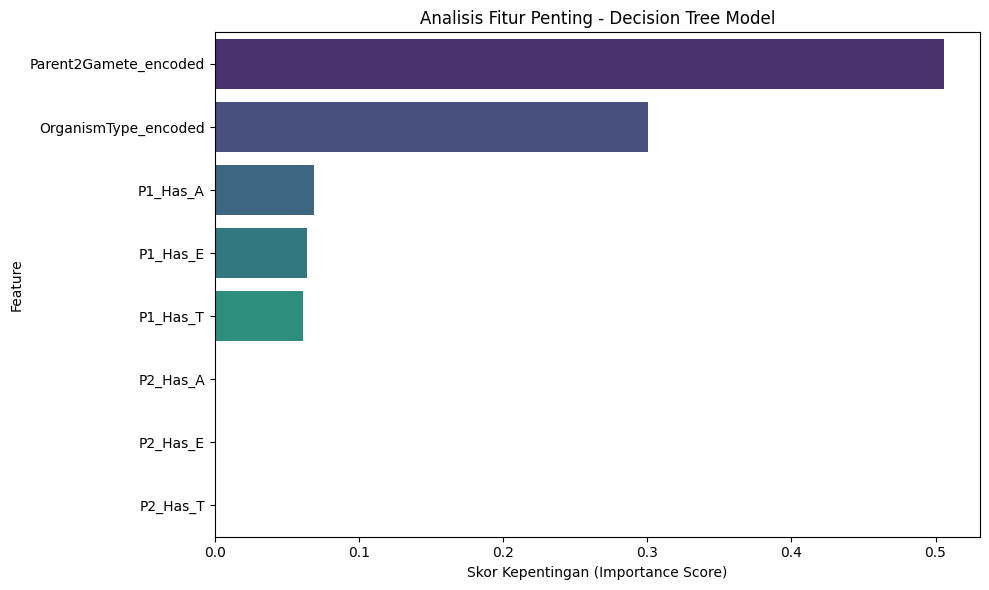

In [7]:
# ====================================================================================
# MODEL 1: DECISION TREE
# ====================================================================================

print("=" * 70)
print("DECISION TREE CLASSIFIER")
print("=" * 70)

# Definisikan parameter untuk grid search
# Parameter-parameter ini dipilih untuk mencegah overfitting
dt_params = {
    'max_depth': [2, 3, 4, 5],         # Kedalaman maksimum tree (dibatasi untuk mencegah overfitting)
    'min_samples_split': [10, 20, 40],  # Minimal sampel untuk split node (tinggi = mengurangi kompleksitas)
    'min_samples_leaf': [5, 10, 20],    # Minimal sampel dalam leaf node (tinggi = lebih stabil)
    'criterion': ['gini', 'entropy'],   # Kriteria untuk mengukur kualitas split
    'ccp_alpha': [0.01, 0.05, 0.1]     # Parameter pruning: cost-complexity (>0 = lebih sederhana)
}

# Penjelasan Parameter Decision Tree:
# - max_depth: Membatasi kedalaman maksimum pohon keputusan untuk mencegah overfitting.
#   Pohon yang terlalu dalam cenderung menghafalkan data training (overfitting).
# - min_samples_split: Jumlah minimal sampel yang diperlukan untuk memecah node internal.
#   Nilai yang lebih tinggi membuat model lebih sederhana dan mengurangi overfitting.
# - min_samples_leaf: Jumlah minimal sampel yang harus berada di node daun.
#   Nilai yang lebih tinggi mencegah model membuat keputusan berdasarkan sampel terlalu sedikit.
# - criterion: Metode untuk mengukur kualitas split (gini = ketidakmurnian, entropy = gain informasi).
# - ccp_alpha: Parameter pruning yang memangkas cabang yang kurang relevan.
#   Nilai yang lebih tinggi menghasilkan pohon yang lebih sederhana.

# Proses Hyperparameter Tuning menggunakan GridSearchCV dengan 10-fold cross-validation
# Ini akan mencoba kombinasi parameter dan memilih yang terbaik berdasarkan akurasi

# Inisialisasi model Decision Tree dengan class_weight untuk mengatasi ketidakseimbangan
# Gunakan hanya fitur terpilih

dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Lakukan grid search untuk menemukan parameter terbaik dengan 10-fold cross-validation
dt_grid = GridSearchCV(dt, dt_params, cv=10, scoring='accuracy', n_jobs=-1)

# y_train and y_test are already defined and aligned with X_train and X_test

# Apply SMOTE to handle class imbalance
print("\nMenerapkan SMOTE untuk mengatasi ketidakseimbangan kelas...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Latih model menggunakan data yang sudah di-resampling dengan SMOTE
print("\nMemulai pelatihan model Decision Tree dengan Grid Search...")
dt_grid.fit(X_train_smote, y_train_smote)

# Ambil model terbaik dari hasil grid search
best_dt = dt_grid.best_estimator_
print(f"\nParameter terbaik yang ditemukan:")
for param, value in dt_grid.best_params_.items():
    print(f"- {param}: {value}")

# Prediksi menggunakan model terbaik pada data testing
y_pred_dt = best_dt.predict(X_test)

# ====================================================================================
# EVALUASI PERFORMA MODEL DECISION TREE
# ====================================================================================

# Hitung berbagai metrik evaluasi
accuracy_dt = accuracy_score(y_test, y_pred_dt)
balanced_accuracy_dt = balanced_accuracy_score(y_test, y_pred_dt)
print(f"\nEvaluasi Model Decision Tree:")
print(f"- Accuracy: {accuracy_dt:.4f} (proporsi prediksi yang benar)")
print(f"- Balanced Accuracy: {balanced_accuracy_dt:.4f} (rata-rata recall untuk setiap kelas, baik untuk data tidak seimbang)")

# Cross-validation untuk mengukur stabilitas model dan generalisasi
# Ini menjalankan model pada berbagai subset data untuk memastikan performa konsisten
cv_scores_dt = cross_val_score(best_dt, X, y, cv=5)
print(f"\n5-Fold Cross-validation scores: {cv_scores_dt}")
print(f"- Mean CV accuracy: {cv_scores_dt.mean():.4f}")
print(f"- Std deviation: {cv_scores_dt.std():.4f}")
print(f"- 95% confidence interval: {cv_scores_dt.mean():.4f} ± {cv_scores_dt.std() * 2:.4f}")

# Periksa overfitting dengan membandingkan akurasi training vs testing
# Gap yang besar menunjukkan model menghafal data training daripada belajar pola umum
train_accuracy = best_dt.score(X_train_smote, y_train_smote)
overfitting_gap = train_accuracy - accuracy_dt
print(f"\nAnalisis Overfitting:")
print(f"- Akurasi pada training set: {train_accuracy:.4f}")
print(f"- Akurasi pada testing set: {accuracy_dt:.4f}")
print(f"- Gap overfitting: {overfitting_gap:.4f} " +
      ("(Overfitting tinggi)" if overfitting_gap > 0.1 else
      "(Overfitting sedang)" if overfitting_gap > 0.05 else "(Overfitting rendah)"))

# Classification report untuk melihat performa per kelas
# Ini memberikan precision, recall, dan f1-score untuk setiap kelas
target_names = label_encoders['OffspringGenotype'].classes_
print("\nClassification Report (Decision Tree):")
print(classification_report(y_test, y_pred_dt, target_names=target_names))

# Analisis fitur importance - fitur mana yang paling berpengaruh dalam model
# Feature importance menunjukkan kontribusi relatif setiap fitur dalam prediksi
feature_importance_dt = pd.DataFrame({
    'Feature': selected_features,
    'Importance': best_dt.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (Decision Tree):")
print(feature_importance_dt)

# Penjelasan Feature Importance:
# - Feature importance menunjukkan kontribusi relatif setiap fitur dalam prediksi
# - Nilai yang lebih tinggi menandakan fitur tersebut lebih berpengaruh dalam keputusan model
# - Hal ini membantu kita memahami faktor genetik apa yang paling menentukan fenotipe keturunan

# Visualisasi feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_dt, x='Importance', y='Feature', palette='viridis')
plt.title('Analisis Fitur Penting - Decision Tree Model')
plt.xlabel('Skor Kepentingan (Importance Score)')
plt.tight_layout()
plt.show()

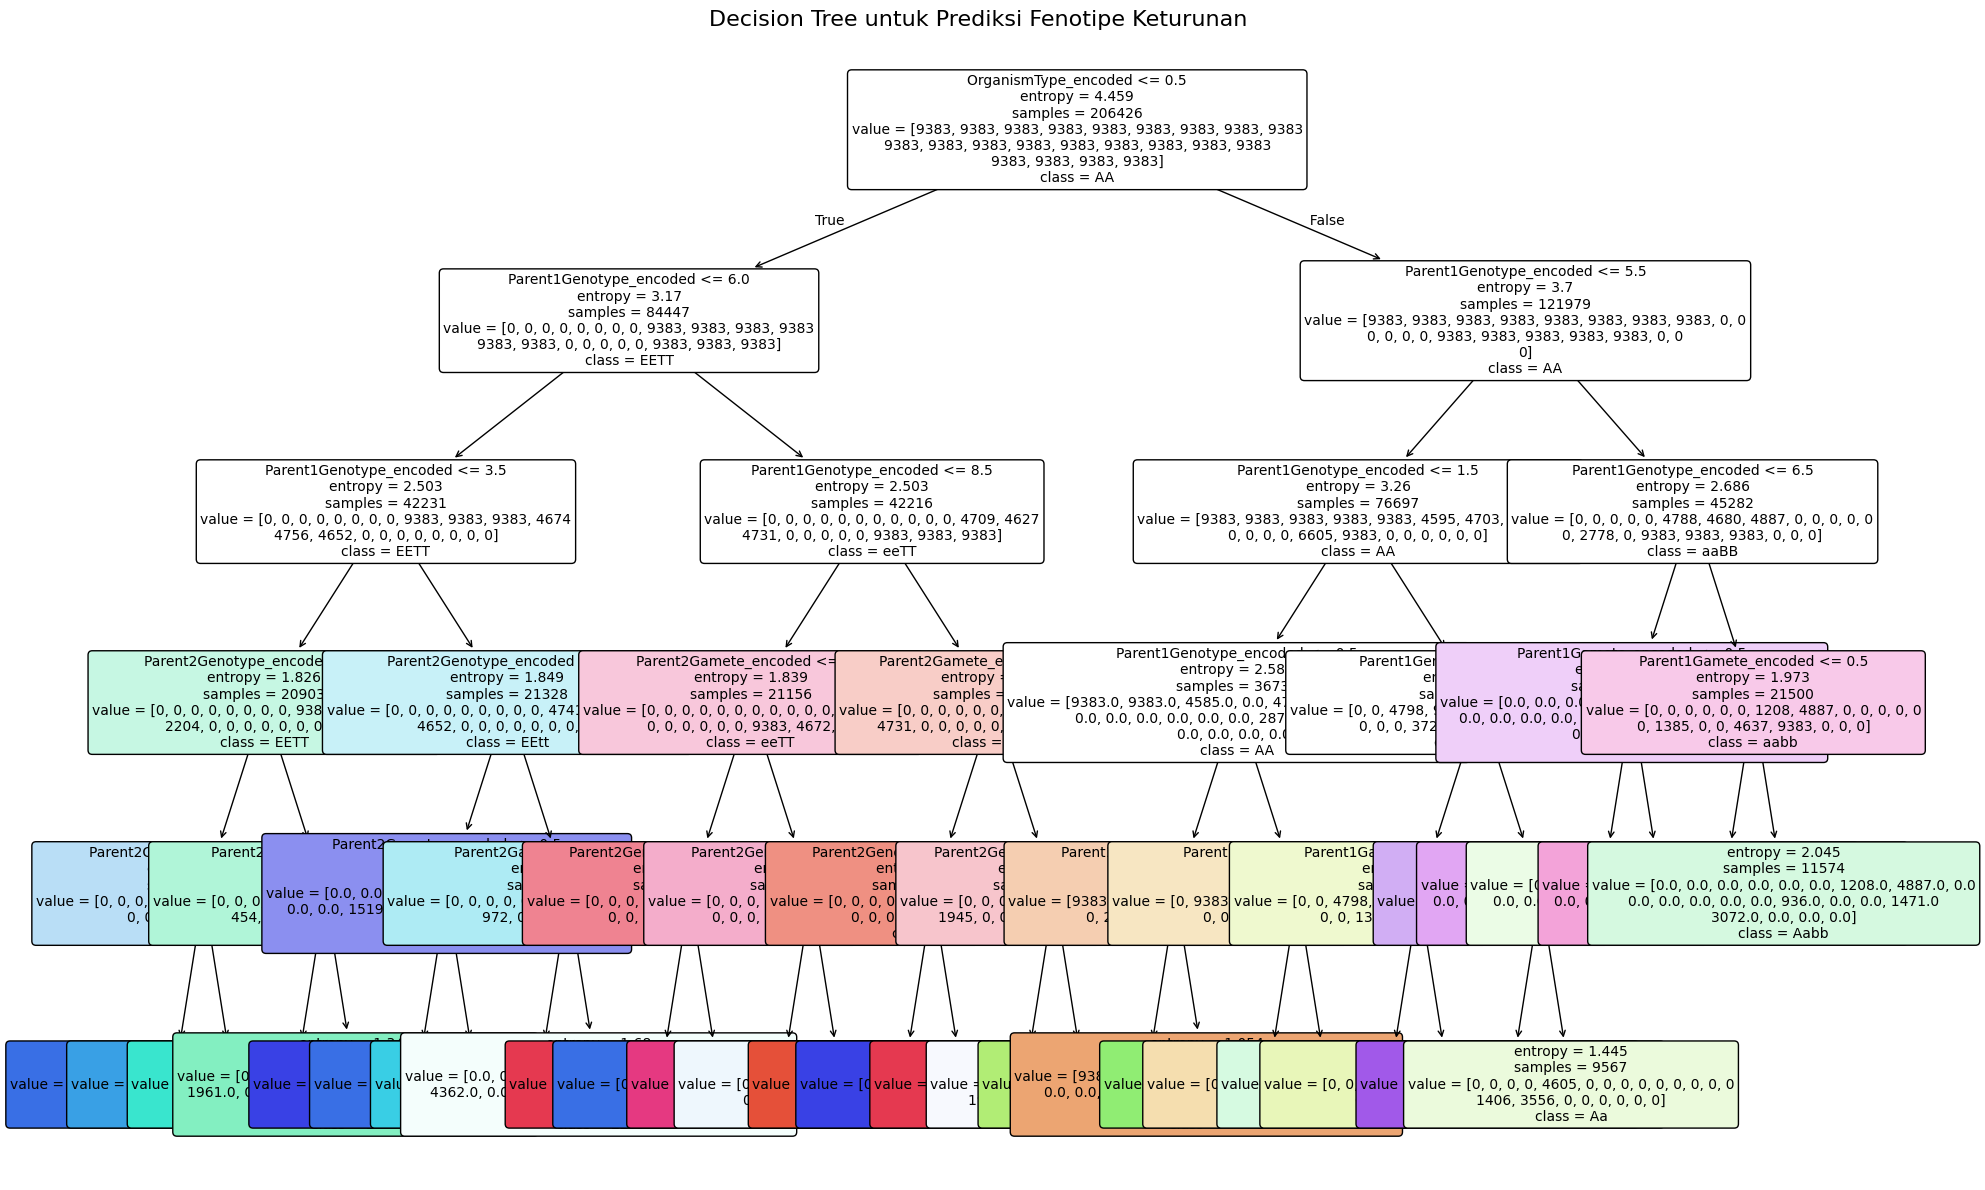

In [8]:
# Visualisasi Decision Tree
plt.figure(figsize=(20, 12))
plot_tree(
    best_dt,
    feature_names=feature_columns,
    class_names=target_names,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title('Decision Tree untuk Prediksi Fenotipe Keturunan', fontsize=16)
plt.tight_layout()
plt.show()

### 3.2 Naive Bayes Classifier

NAIVE BAYES CLASSIFIER

Parameter terbaik: var_smoothing = 1e-09

Evaluasi Model Naive Bayes:
- Accuracy: 0.3479
- Balanced Accuracy: 0.5433

Parameter terbaik: var_smoothing = 1e-09

Evaluasi Model Naive Bayes:
- Accuracy: 0.3479
- Balanced Accuracy: 0.5433

10-Fold Cross-validation scores: [0.7168 0.7164 0.7124 0.7196 0.7182 0.7148 0.7168 0.7134 0.72   0.722 ]
- Mean CV accuracy: 0.7170
- Std deviation: 0.0029
- 95% confidence interval: 0.7170 ± 0.0057

10-Fold Cross-validation scores: [0.7168 0.7164 0.7124 0.7196 0.7182 0.7148 0.7168 0.7134 0.72   0.722 ]
- Mean CV accuracy: 0.7170
- Std deviation: 0.0029
- 95% confidence interval: 0.7170 ± 0.0057

Analisis Overfitting:
- Akurasi pada training set: 0.5387
- Akurasi pada testing set: 0.3479
- Gap overfitting: 0.1908 (Overfitting tinggi)

Classification Report (Naive Bayes):
              precision    recall  f1-score   support

          AA       0.31      1.00      0.47       184
        AABB       0.11      1.00      0.20        22

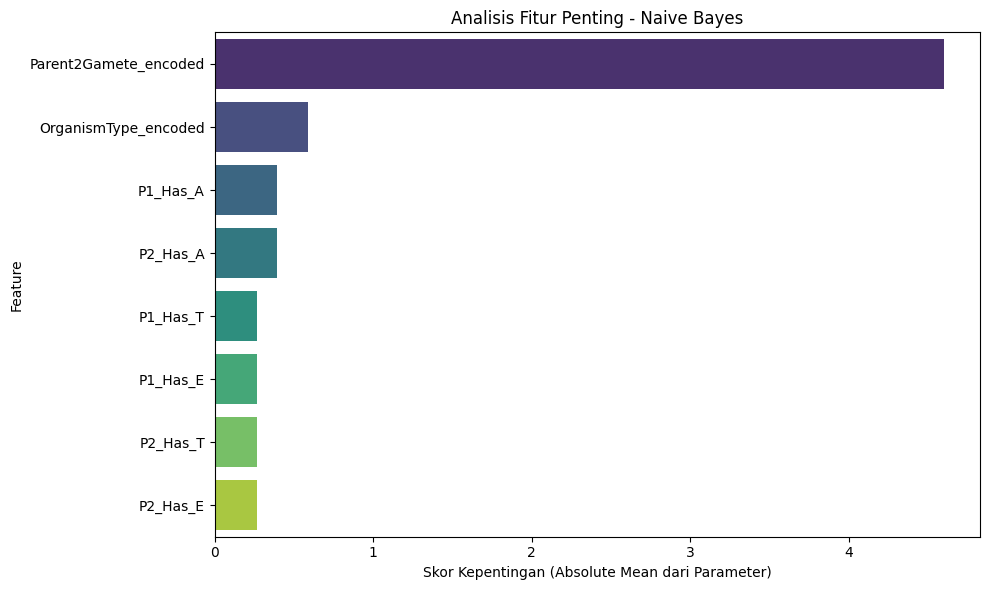

In [9]:
# ====================================================================================
# MODEL 2: NAIVE BAYES CLASSIFIER
# ====================================================================================

print("=" * 70)
print("NAIVE BAYES CLASSIFIER")
print("=" * 70)

# Parameter untuk optimasi Gaussian Naive Bayes
# Gaussian Naive Bayes bekerja baik dengan data kontinyu
# Gunakan SMOTE dan 10-fold cross-validation

gnb_params = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

gnb = GaussianNB()
gnb_grid = GridSearchCV(gnb, gnb_params, cv=10, scoring='accuracy', n_jobs=-1)
gnb_grid.fit(X_train_smote, y_train_smote)

best_nb = gnb_grid.best_estimator_
print(f"\nParameter terbaik: var_smoothing = {gnb_grid.best_params_['var_smoothing']}")

y_pred_nb = best_nb.predict(X_test)

# ====================================================================================
# EVALUASI PERFORMA MODEL NAIVE BAYES
# ====================================================================================

accuracy_nb = accuracy_score(y_test, y_pred_nb)
balanced_accuracy_nb = balanced_accuracy_score(y_test, y_pred_nb)
print(f"\nEvaluasi Model Naive Bayes:")
print(f"- Accuracy: {accuracy_nb:.4f}")
print(f"- Balanced Accuracy: {balanced_accuracy_nb:.4f}")

# Cross-validation dengan 10-fold
cv_scores_nb = cross_val_score(best_nb, X, y, cv=10)
print(f"\n10-Fold Cross-validation scores: {cv_scores_nb}")
print(f"- Mean CV accuracy: {cv_scores_nb.mean():.4f}")
print(f"- Std deviation: {cv_scores_nb.std():.4f}")
print(f"- 95% confidence interval: {cv_scores_nb.mean():.4f} ± {cv_scores_nb.std() * 2:.4f}")

# Periksa overfitting
train_acc_nb = accuracy_score(y_train_smote, best_nb.predict(X_train_smote))
overfitting_nb = train_acc_nb - accuracy_nb
print(f"\nAnalisis Overfitting:")
print(f"- Akurasi pada training set: {train_acc_nb:.4f}")
print(f"- Akurasi pada testing set: {accuracy_nb:.4f}")
print(f"- Gap overfitting: {overfitting_nb:.4f} " +
      ("(Overfitting tinggi)" if overfitting_nb > 0.1 else
      "(Overfitting sedang)" if overfitting_nb > 0.05 else "(Overfitting rendah)"))

print("\nClassification Report (Naive Bayes):")
print(classification_report(y_test, y_pred_nb, target_names=target_names))

# Feature importance (absolute mean of theta)
feature_importance_nb = pd.DataFrame({
    'Feature': selected_features,
    'Importance': np.abs(best_nb.theta_).mean(axis=0)
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (Naive Bayes):")
print(feature_importance_nb)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_nb, x='Importance', y='Feature', palette='viridis')
plt.title('Analisis Fitur Penting - Naive Bayes')
plt.xlabel('Skor Kepentingan (Absolute Mean dari Parameter)')
plt.tight_layout()
plt.show()

### 3.3 KNN

In [10]:
# ====================================================================================
# MODEL 3: K-NEAREST NEIGHBORS (KNN) CLASSIFIER
# ====================================================================================

print("=" * 70)
print("K-NEAREST NEIGHBORS (KNN) CLASSIFIER")
print("=" * 70)

# KNN adalah algoritma non-parametrik yang mengklasifikasikan sampel berdasarkan mayoritas label dari k tetangga terdekat di ruang fitur.
# Model ini sensitif terhadap skala fitur, sehingga kita gunakan data yang sudah diskalakan (X_train_smote_scaled, X_test_scaled).

# Parameter untuk Grid Search pada KNN
knn_params = {
    'n_neighbors': [3, 5, 7, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, knn_params, cv=10, scoring='accuracy', n_jobs=-1)
knn_grid.fit(X_train_smote_scaled, y_train_smote)

best_knn = knn_grid.best_estimator_
print(f"\nParameter terbaik yang ditemukan:")
for param, value in knn_grid.best_params_.items():
    print(f"- {param}: {value}")

y_pred_knn = best_knn.predict(X_test_scaled)

# ====================================================================================
# EVALUASI PERFORMA MODEL KNN
# ====================================================================================

accuracy_knn = accuracy_score(y_test, y_pred_knn)
balanced_accuracy_knn = balanced_accuracy_score(y_test, y_pred_knn)
print(f"\nEvaluasi Model KNN:")
print(f"- Accuracy: {accuracy_knn:.4f}")
print(f"- Balanced Accuracy: {balanced_accuracy_knn:.4f}")

# Cross-validation dengan 10-fold
cv_scores_knn = cross_val_score(best_knn, X, y, cv=10)
print(f"\n10-Fold Cross-validation scores: {cv_scores_knn}")
print(f"- Mean CV accuracy: {cv_scores_knn.mean():.4f}")
print(f"- Std deviation: {cv_scores_knn.std():.4f}")
print(f"- 95% confidence interval: {cv_scores_knn.mean():.4f} ± {cv_scores_knn.std() * 2:.4f}")

# Periksa overfitting
train_acc_knn = accuracy_score(y_train_smote, best_knn.predict(X_train_smote_scaled))
overfitting_knn = train_acc_knn - accuracy_knn
print(f"\nAnalisis Overfitting:")
print(f"- Akurasi pada training set: {train_acc_knn:.4f}")
print(f"- Akurasi pada testing set: {accuracy_knn:.4f}")
print(f"- Gap overfitting: {overfitting_knn:.4f} " +
      ("(Overfitting tinggi)" if overfitting_knn > 0.1 else
      "(Overfitting sedang)" if overfitting_knn > 0.05 else "(Overfitting rendah)"))

print("\nClassification Report (KNN):")
print(classification_report(y_test, y_pred_knn, target_names=target_names))

# Feature importance tidak tersedia pada KNN, namun kita bisa tampilkan feature importances dari model lain untuk referensi
print("\nKNN tidak memiliki feature importance secara langsung.")

K-NEAREST NEIGHBORS (KNN) CLASSIFIER

Parameter terbaik yang ditemukan:
- metric: euclidean
- n_neighbors: 3
- weights: uniform

Parameter terbaik yang ditemukan:
- metric: euclidean
- n_neighbors: 3
- weights: uniform

Evaluasi Model KNN:
- Accuracy: 0.5649
- Balanced Accuracy: 0.4512

Evaluasi Model KNN:
- Accuracy: 0.5649
- Balanced Accuracy: 0.4512

10-Fold Cross-validation scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
- Mean CV accuracy: 1.0000
- Std deviation: 0.0000
- 95% confidence interval: 1.0000 ± 0.0000

10-Fold Cross-validation scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
- Mean CV accuracy: 1.0000
- Std deviation: 0.0000
- 95% confidence interval: 1.0000 ± 0.0000

Analisis Overfitting:
- Akurasi pada training set: 0.4537
- Akurasi pada testing set: 0.5649
- Gap overfitting: -0.1112 (Overfitting rendah)

Classification Report (KNN):
              precision    recall  f1-score   support

          AA       0.31      1.00      0.47       184
        AABB       0.00      0.00      0.00 

## 4. Perbandingan Model dan Analisis

In [11]:
# ====================================================================================
# PERBANDINGAN KOMPREHENSIF PERFORMA MODEL
# ====================================================================================

print("=" * 80)
print("PERBANDINGAN KOMPREHENSIF PERFORMA MODEL")
print("=" * 80)

# Bagian ini membandingkan performa ketiga model yang telah dilatih:
# 1. Decision Tree - model berbasis pohon keputusan yang mudah diinterpretasi
# 2. Naive Bayes - model probabilistik berdasarkan teorema Bayes
# 3. Logistic Regression - model linear untuk klasifikasi

# Menghitung metrik tambahan untuk setiap model
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

def calculate_multiclass_roc_auc(y_true, y_pred_proba, classes):
    """
    Menghitung ROC AUC untuk kasus multiclass menggunakan pendekatan one-vs-rest.

    Args:
        y_true: Label sebenarnya
        y_pred_proba: Probabilitas prediksi untuk setiap kelas
        classes: Daftar kelas unik

    Returns:
        Nilai ROC AUC
    """
    # Binarize target untuk pendekatan one-vs-rest
    y_true_bin = label_binarize(y_true, classes=range(len(classes)))

    # Kasus khusus untuk binary classification
    if len(classes) == 2:
        return roc_auc_score(y_true_bin, y_pred_proba[:, 1])
    else:
        return roc_auc_score(y_true_bin, y_pred_proba, multi_class='ovr')

# Pastikan cv_scores_lr sudah dihitung
if 'cv_scores_lr' not in globals():
    print("Menghitung cross-validation scores untuk Logistic Regression...")
    cv_scores_lr = cross_val_score(best_lr, X, y, cv=5)

# Mendapatkan probabilitas prediksi dari masing-masing model
# Memastikan semua model diproses dengan cara yang sama
y_pred_dt = best_dt.predict(X_test)
y_pred_proba_dt = best_dt.predict_proba(X_test)

y_pred_nb = best_nb.predict(X_test)
y_pred_proba_nb = best_nb.predict_proba(X_test)

y_pred_lr = best_lr.predict(X_test_scaled)  # Menggunakan data yang sudah discaling
y_pred_proba_lr = best_lr.predict_proba(X_test_scaled)

# Menghitung accuracy untuk setiap model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
accuracy_lr = accuracy_score(y_test, y_pred_lr)

# Menghitung perbedaan akurasi training vs testing (untuk mengukur overfitting)
train_acc_dt = accuracy_score(y_train_smote, best_dt.predict(X_train_smote))
train_acc_nb = accuracy_score(y_train_smote, best_nb.predict(X_train_smote))
# Pastikan data SMOTE sudah di-scale untuk logistic regression
train_acc_lr = accuracy_score(y_train_smote, best_lr.predict(X_train_smote_scaled))

# Hitung gap overfitting untuk setiap model
overfitting_dt = train_acc_dt - accuracy_dt
overfitting_nb = train_acc_nb - accuracy_nb
overfitting_lr = train_acc_lr - accuracy_lr

# Menghitung F1 score (macro average) - metrik yang baik untuk data tidak seimbang
f1_dt = f1_score(y_test, y_pred_dt, average='macro')
f1_nb = f1_score(y_test, y_pred_nb, average='macro')
f1_lr = f1_score(y_test, y_pred_lr, average='macro')

# Menghitung ROC AUC for all models with the same method
unique_classes = np.unique(y)
roc_auc_dt = calculate_multiclass_roc_auc(y_test, y_pred_proba_dt, unique_classes)
roc_auc_nb = calculate_multiclass_roc_auc(y_test, y_pred_proba_nb, unique_classes)
roc_auc_lr = calculate_multiclass_roc_auc(y_test, y_pred_proba_lr, unique_classes)

# Membuat tabel performa komprehensif dengan semua model
results_summary = pd.DataFrame({
    'Model': ['Decision Tree', 'Naive Bayes', 'Logistic Regression'],
    'Test Accuracy': [accuracy_dt, accuracy_nb, accuracy_lr],
    'Training Accuracy': [train_acc_dt, train_acc_nb, train_acc_lr],
    'Overfitting Gap': [overfitting_dt, overfitting_nb, overfitting_lr],
    'Balanced Accuracy': [balanced_accuracy_score(y_test, y_pred_dt),
                          balanced_accuracy_score(y_test, y_pred_nb),
                          balanced_accuracy_score(y_test, y_pred_lr)],
    'F1 Score (Macro)': [f1_dt, f1_nb, f1_lr],
    'ROC AUC': [roc_auc_dt, roc_auc_nb, roc_auc_lr],
    'CV Mean': [cv_scores_dt.mean(), cv_scores_nb.mean(), cv_scores_lr.mean()],
    'CV Std': [cv_scores_dt.std(), cv_scores_nb.std(), cv_scores_lr.std()]
})

# Urutkan berdasarkan balanced accuracy (lebih baik untuk dataset tidak seimbang)
results_summary = results_summary.sort_values('Balanced Accuracy', ascending=False)
print("\nRingkasan Performa Model (diurutkan berdasarkan Balanced Accuracy):")
print(results_summary.round(4))

# Penjelasan Metrik Evaluasi:
# - Test Accuracy: Proporsi prediksi yang benar pada data testing
# - Training Accuracy: Proporsi prediksi yang benar pada data training
# - Overfitting Gap: Perbedaan antara Training dan Test Accuracy (lebih kecil = lebih baik)
# - Balanced Accuracy: Rata-rata recall untuk setiap kelas (lebih baik untuk data tidak seimbang)
# - F1 Score: Rata-rata harmonik dari precision dan recall
# - ROC AUC: Area di bawah kurva ROC, mengukur kemampuan model membedakan kelas
# - CV Mean: Rata-rata akurasi dari cross-validation
# - CV Std: Standar deviasi dari cross-validation (lebih kecil = model lebih stabil)

# Menyoroti analisis overfitting
print("\n" + "=" * 80)
print("ANALISIS OVERFITTING")
print("=" * 80)
overfitting_df = results_summary[['Model', 'Training Accuracy', 'Test Accuracy', 'Overfitting Gap']].sort_values('Overfitting Gap')
print(overfitting_df.round(4))
print("\nCatatan: 'Overfitting Gap' yang lebih rendah menandakan generalisasi yang lebih baik (lebih kecil = lebih baik)")
print("Gap yang besar antara akurasi training dan testing menunjukkan model cenderung menghafal data training")
print("daripada belajar pola umum yang dapat diterapkan pada data baru.")

PERBANDINGAN KOMPREHENSIF PERFORMA MODEL
Menghitung cross-validation scores untuk Logistic Regression...


NameError: name 'best_lr' is not defined

In [ ]:
# ====================================================================================
# ANALISIS CONFUSION MATRIX
# ====================================================================================

# Confusion Matrix menunjukkan jumlah prediksi benar dan salah untuk setiap kelas
# - Diagonal utama (kiri atas ke kanan bawah): Menunjukkan prediksi yang benar (True Positives)
# - Sel lainnya: Menunjukkan prediksi yang salah dan kelas yang keliru diprediksi

# Pentingnya Confusion Matrix:
# 1. Mengidentifikasi kelas yang sulit diprediksi oleh model
# 2. Mendeteksi pola kesalahan spesifik (misal, kelas A sering salah diprediksi sebagai kelas B)
# 3. Membantu mengevaluasi model pada situasi dengan biaya kesalahan yang berbeda

print("=" * 80)
print("ANALISIS CONFUSION MATRIX")
print("=" * 80)

# Pastikan y_pred_lr telah didefinisikan
if 'y_pred_lr' not in globals():
    print("Menghitung prediksi untuk Logistic Regression...")
    y_pred_lr = best_lr.predict(X_test_scaled)

# Visualisasi Confusion Matrix untuk semua model (Decision Tree, Naive Bayes, Logistic Regression)
plt.figure(figsize=(15, 8))

# Daftar model dengan hasil prediksinya
models = [
    ('Decision Tree', y_pred_dt),
    ('Naive Bayes', y_pred_nb),
    ('Logistic Regression', y_pred_lr)
]

# Buat subplot untuk setiap model
for idx, (name, y_pred) in enumerate(models):
    plt.subplot(1, 3, idx+1)

    # Hitung confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Visualisasikan dengan heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')

    # Hitung dan tampilkan beberapa metrik dari confusion matrix
    TP = np.diag(cm)  # True Positives untuk setiap kelas (diagonal)
    FP = np.sum(cm, axis=0) - TP  # False Positives untuk setiap kelas (jumlah kolom - TP)
    FN = np.sum(cm, axis=1) - TP  # False Negatives untuk setiap kelas (jumlah baris - TP)

    # Cetak metrik per kelas untuk model saat ini
    print(f"\n--- Model: {name} ---")
    for i, class_name in enumerate(target_names):
        precision = TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) > 0 else 0
        recall = TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0
        print(f"Kelas '{class_name}':")
        print(f"- True Positives: {TP[i]} (benar diprediksi sebagai '{class_name}')")
        print(f"- False Positives: {FP[i]} (salah diprediksi sebagai '{class_name}')")
        print(f"- False Negatives: {FN[i]} ('{class_name}' salah diprediksi sebagai kelas lain)")
        print(f"- Precision: {precision:.2f}")
        print(f"- Recall: {recall:.2f}")

plt.tight_layout()
plt.show()

## 5. Sistem Prediksi Interaktif Terpadu

Sistem prediksi interaktif di bawah ini mengintegrasikan model machine learning yang telah dilatih untuk memprediksi fenotipe keturunan dari persilangan organisme Flora dan Fauna. Sistem ini memungkinkan pengguna untuk:

1. **Memilih Tipe Organisme** - Flora (tumbuhan) atau Fauna (hewan)
2. **Menentukan Genotipe Induk** - Informasi genetik lengkap dari kedua induk
3. **Memilih Gamet** - Sel reproduksi haploid yang dihasilkan masing-masing induk
4. **Mengatur Threshold Confidence** - Batas keyakinan minimal untuk menerima prediksi

### Prinsip Biologis Sistem Prediksi:

#### Untuk Flora:
- **Alel A/a**: Menentukan warna bunga (A=ungu, a=putih)
- **Alel B/b**: Menentukan bentuk biji (B=bulat, b=keriput)
- **Pola Pewarisan**: Mengikuti Hukum Mendel tentang segregasi dan pewarisan independen

#### Untuk Fauna:
- **Alel E/e**: Menentukan warna coat (E=coklat, e=hitam)
- **Alel T/t**: Menentukan panjang ekor (T=pendek, t=panjang)
- **Pola Pewarisan**: Serupa dengan Flora, tetapi dengan set alel berbeda

Sistem ini menggunakan tiga model machine learning (Decision Tree, Naive Bayes, dan Logistic Regression) untuk memberikan prediksi komprehensif dan meningkatkan akurasi. Setiap prediksi disertai nilai confidence yang membantu pengguna memahami tingkat kepercayaan terhadap hasil prediksi.

In [ ]:
# ====================================================================================
# FUNGSI PREDIKSI FENOTIPE KETURUNAN
# ====================================================================================

def predict_offspring_phenotype(organism_type, parent1_genotype, parent1_gamete, parent2_genotype, parent2_gamete):
    """
    Prediksi fenotipe keturunan berdasarkan input pengguna menggunakan model ML yang telah dilatih

    Args:
        organism_type: 'Flora' atau 'Fauna'
        parent1_genotype: Genotipe induk pertama
        parent1_gamete: Gamet yang dihasilkan induk pertama
        parent2_genotype: Genotipe induk kedua
        parent2_gamete: Gamet yang dihasilkan induk kedua

    Returns:
        Dictionary berisi prediksi dari semua model dan probabilitas untuk setiap kelas
    """
    # Verifikasi input - pastikan organism_type valid
    if organism_type not in df['OrganismType'].unique():
        return {"error": f"Tipe organisme tidak dikenal: {organism_type}. Harus 'Flora' atau 'Fauna'"}

    # Persiapkan nilai fitur untuk prediksi
    try:
        # Lakukan encoding menggunakan label encoder yang sudah dilatih sebelumnya
        organism_encoded = label_encoders['OrganismType'].transform([organism_type])[0]
        parent1_genotype_encoded = label_encoders['Parent1Genotype'].transform([parent1_genotype])[0]
        parent1_gamete_encoded = label_encoders['Parent1Gamete'].transform([parent1_gamete])[0]
        parent2_genotype_encoded = label_encoders['Parent2Genotype'].transform([parent2_genotype])[0]
        parent2_gamete_encoded = label_encoders['Parent2Gamete'].transform([parent2_gamete])[0]

        # Ekstrak fitur berdasarkan genotipe untuk induk 1
        # Deteksi keberadaan alel pada genotipe
        p1_has_A = 'A' in parent1_genotype if organism_type == 'Flora' else False
        p1_has_B = 'B' in parent1_genotype if organism_type == 'Flora' else False
        p1_has_E = 'E' in parent1_genotype if organism_type == 'Fauna' else False
        p1_has_T = 'T' in parent1_genotype if organism_type == 'Fauna' else False

        # Ekstrak fitur berdasarkan genotipe untuk induk 2
        p2_has_A = 'A' in parent2_genotype if organism_type == 'Flora' else False
        p2_has_B = 'B' in parent2_genotype if organism_type == 'Flora' else False
        p2_has_E = 'E' in parent2_genotype if organism_type == 'Fauna' else False
        p2_has_T = 'T' in parent2_genotype if organism_type == 'Fauna' else False

    except ValueError as e:
        return {"error": f"Nilai tidak dikenal dalam input - {e}"}

    # Buat fitur input sesuai dengan format yang diharapkan oleh model
    input_features = np.array([[
        organism_encoded,
        parent1_genotype_encoded, parent1_gamete_encoded,
        parent2_genotype_encoded, parent2_gamete_encoded,
        p1_has_A, p1_has_B, p1_has_E, p1_has_T,
        p2_has_A, p2_has_B, p2_has_E, p2_has_T
    ]])

    # Pilih fitur yang dipilih oleh selector
    input_features_selected = selector.transform(input_features)

    # Scaling data untuk Logistic Regression yang sensitif terhadap skala
    input_features_scaled = scaler.transform(input_features_selected)

    # Buat prediksi dengan semua model yang telah dilatih
    predictions = {}

    try:
        # Decision Tree - tidak memerlukan scaling
        pred_dt = best_dt.predict(input_features_selected)[0]
        prob_dt = best_dt.predict_proba(input_features_selected)[0]
        predictions['Decision Tree'] = {
            'prediction': label_encoders['OffspringGenotype'].inverse_transform([pred_dt])[0],
            'probabilities': dict(zip(label_encoders['OffspringGenotype'].classes_, prob_dt))
        }

        # Naive Bayes - tidak memerlukan scaling
        pred_nb = best_nb.predict(input_features_selected)[0]
        prob_nb = best_nb.predict_proba(input_features_selected)[0]
        predictions['Naive Bayes'] = {
            'prediction': label_encoders['OffspringGenotype'].inverse_transform([pred_nb])[0],
            'probabilities': dict(zip(label_encoders['OffspringGenotype'].classes_, prob_nb))
        }

        # Logistic Regression - memerlukan data yang sudah discaling
        pred_lr = best_lr.predict(input_features_scaled)[0]
        prob_lr = best_lr.predict_proba(input_features_scaled)[0]
        predictions['Logistic Regression'] = {
            'prediction': label_encoders['OffspringGenotype'].inverse_transform([pred_lr])[0],
            'probabilities': dict(zip(label_encoders['OffspringGenotype'].classes_, prob_lr))
        }

    except Exception as e:
        return {"error": f"Prediksi gagal - {e}"}

    return predictions

In [ ]:
# ====================================================================================
# FUNGSI PREDIKSI BERDASARKAN KOMBINASI GAMET DARI DUA INDUK
# ====================================================================================

def predict_offspring_from_parents(organism_type, parent1_genotype, parent1_gamete, parent2_genotype, parent2_gamete):
    """
    Prediksi fenotipe keturunan berdasarkan gamet dari dua induk dan menghitung genotipe keturunan

    Args:
        organism_type: 'Flora' atau 'Fauna'
        parent1_genotype: Genotipe induk pertama
        parent1_gamete: Gamet dari induk pertama
        parent2_genotype: Genotipe induk kedua
        parent2_gamete: Gamet dari induk kedua

    Returns:
        Dictionary berisi prediksi fenotipe keturunan, genotipe keturunan, dan informasi lainnya
    """
    # Validasi organism_type
    if organism_type not in ['Flora', 'Fauna']:
        return {"error": f"Tipe organisme tidak dikenal: {organism_type}. Harus 'Flora' atau 'Fauna'"}

    # Hitung genotipe keturunan berdasarkan kombinasi gamet
    calculated_genotype = None

    try:
        # === Logika untuk menentukan genotipe keturunan berdasarkan kombinasi gamet ===
        if organism_type == 'Flora':
            # Kasus Flora - untuk satu sifat (A/a)
            if len(parent1_gamete) == 1 and len(parent2_gamete) == 1:
                # Gabungkan kedua gamet dan urutkan untuk konsistensi (Aa bukan aA)
                calculated_genotype = ''.join(sorted([parent1_gamete, parent2_gamete]))

            # Kasus Flora - untuk dua sifat (AB/Ab/aB/ab)
            elif len(parent1_gamete) == 2 and len(parent2_gamete) == 2:
                # Pisahkan allele untuk setiap sifat
                p1_first = parent1_gamete[0]   # Sifat pertama dari induk 1 (A/a)
                p1_second = parent1_gamete[1]  # Sifat kedua dari induk 1 (B/b)
                p2_first = parent2_gamete[0]   # Sifat pertama dari induk 2 (A/a)
                p2_second = parent2_gamete[1]  # Sifat kedua dari induk 2 (B/b)

                # Kombinasikan dan urutkan untuk masing-masing sifat
                first_trait = ''.join(sorted([p1_first, p2_first]))   # Sifat pertama keturunan (AA/Aa/aa)
                second_trait = ''.join(sorted([p1_second, p2_second])) # Sifat kedua keturunan (BB/Bb/bb)

                calculated_genotype = first_trait + second_trait        # Gabungkan kedua sifat
            else:
                return {"error": "Gamet tidak kompatibel untuk Flora"}

        elif organism_type == 'Fauna':
            # Fauna selalu memiliki dua sifat (ET/Et/eT/et)
            if len(parent1_gamete) == 2 and len(parent2_gamete) == 2:
                # Pisahkan allele untuk setiap sifat
                p1_first = parent1_gamete[0]   # Sifat pertama dari induk 1 (E/e)
                p1_second = parent1_gamete[1]  # Sifat kedua dari induk 1 (T/t)
                p2_first = parent2_gamete[0]   # Sifat pertama dari induk 2 (E/e)
                p2_second = parent2_gamete[1]  # Sifat kedua dari induk 2 (T/t)

                # Kombinasikan dan urutkan untuk masing-masing sifat
                first_trait = ''.join(sorted([p1_first, p2_first]))   # Sifat warna (EE/Ee/ee)
                second_trait = ''.join(sorted([p1_second, p2_second])) # Sifat panjang ekor (TT/Tt/tt)

                calculated_genotype = first_trait + second_trait        # Gabungkan kedua sifat
            else:
                return {"error": "Gamet tidak kompatibel untuk Fauna"}

        # Gunakan fungsi prediksi untuk memprediksi fenotipe dari hasil persilangan
        predictions = predict_offspring_phenotype(
            organism_type,
            parent1_genotype, parent1_gamete,
            parent2_genotype, parent2_gamete
        )

        # Tambahkan informasi tentang genotipe offspring
        if "error" not in predictions:
            predictions["calculated_genotype"] = calculated_genotype

        return predictions

    except Exception as e:
        return {"error": f"Error dalam prediksi: {str(e)}"}

# Fungsi prediksi untuk dua induk telah didefinisikan!
# Fungsi ini menghitung genotipe keturunan berdasarkan prinsip Mendel dan memprediksi fenotipe.
# Proses perhitungan:
# 1. Mengkombinasikan gamet dari kedua induk untuk menentukan genotipe keturunan
# 2. Menggunakan model ML untuk memprediksi fenotipe berdasarkan genotipe

In [ ]:
# ====================================================================================
# SISTEM PREDIKSI INTERAKTIF TERPADU (FLORA & FAUNA)
# ====================================================================================
# Sistem ini memprediksi fenotipe keturunan berdasarkan dua induk (Flora/Fauna) dengan genotipe berbeda

print("=" * 80)
print("SISTEM PREDIKSI KETURUNAN TERPADU (FLORA & FAUNA)")
print("=" * 80)

# Mendefinisikan pilihan-pilihan untuk genotipe
flora_genotypes = ['AA', 'Aa', 'aa', 'AABB', 'AABb', 'AAbb', 'AaBB', 'AaBb', 'Aabb', 'aaBB', 'aaBb', 'aabb']
fauna_genotypes = ['EETT', 'EETt', 'EEtt', 'EeTT', 'EeTt', 'Eett', 'eeTT', 'eeTt', 'eett']

# Dictionary untuk menyimpan gametes yang valid untuk setiap genotipe
# Ini mengikuti hukum Mendel tentang segregasi alel selama pembentukan gamet
flora_valid_gametes = {
    'AA': ['A'],         # Homozigot dominan - hanya menghasilkan satu jenis gamet
    'Aa': ['A', 'a'],    # Heterozigot - menghasilkan dua jenis gamet berbeda
    'aa': ['a'],         # Homozigot resesif - hanya menghasilkan satu jenis gamet
    'AABB': ['AB'],      # Homozigot untuk kedua sifat
    'AABb': ['AB', 'Ab'], # Homozigot untuk sifat pertama, heterozigot untuk sifat kedua
    'AAbb': ['Ab'],      # Homozigot untuk kedua sifat (sifat kedua resesif)
    'AaBB': ['AB', 'aB'], # Heterozigot untuk sifat pertama, homozigot untuk sifat kedua
    'AaBb': ['AB', 'Ab', 'aB', 'ab'], # Heterozigot untuk kedua sifat - menghasilkan 4 jenis gamet
    'Aabb': ['Ab', 'ab'], # Heterozigot untuk sifat pertama, homozigot resesif untuk sifat kedua
    'aaBB': ['aB'],      # Homozigot resesif untuk sifat pertama, homozigot dominan untuk sifat kedua
    'aaBb': ['aB', 'ab'], # Homozigot resesif untuk sifat pertama, heterozigot untuk sifat kedua
    'aabb': ['ab']       # Homozigot resesif untuk kedua sifat
}

# Dictionary yang sama untuk fauna, mengikuti pola yang sama tetapi dengan alel E/e dan T/t
fauna_valid_gametes = {
    'EETT': ['ET'],      # Homozigot dominan untuk kedua sifat
    'EETt': ['ET', 'Et'], # Homozigot dominan untuk sifat E, heterozigot untuk sifat T
    'EEtt': ['Et'],      # Homozigot dominan untuk E, homozigot resesif untuk T
    'EeTT': ['ET', 'eT'], # Heterozigot untuk E, homozigot dominan untuk T
    'EeTt': ['ET', 'Et', 'eT', 'et'], # Heterozigot untuk kedua sifat
    'Eett': ['Et', 'et'], # Heterozigot untuk E, homozigot resesif untuk T
    'eeTT': ['eT'],      # Homozigot resesif untuk E, homozigot dominan untuk T
    'eeTt': ['eT', 'et'], # Homozigot resesif untuk E, heterozigot untuk T
    'eett': ['et']       # Homozigot resesif untuk kedua sifat
}

# Membuat widgets untuk input user
organism_type_dropdown = widgets.Dropdown(
    options=['Flora', 'Fauna'],
    value='Flora',
    description='Jenis Organisme:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

# Parent 1 - Widget untuk induk pertama
parent1_title = widgets.HTML(value="<h3>Induk 1</h3>")

parent1_genotype_dropdown = widgets.Dropdown(
    options=flora_genotypes,
    description='Genotipe Induk 1:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

parent1_gamete_dropdown = widgets.Dropdown(
    options=flora_valid_gametes[parent1_genotype_dropdown.value],
    description='Gamet Induk 1:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

# Parent 2 - Widget untuk induk kedua
parent2_title = widgets.HTML(value="<h3>Induk 2</h3>")

parent2_genotype_dropdown = widgets.Dropdown(
    options=flora_genotypes,
    description='Genotipe Induk 2:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

parent2_gamete_dropdown = widgets.Dropdown(
    options=flora_valid_gametes[parent2_genotype_dropdown.value],
    description='Gamet Induk 2:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

# Threshold untuk menyaring prediksi berdasarkan tingkat kepercayaan
confidence_threshold = widgets.FloatSlider(
    value=0.5,
    min=0.0,
    max=1.0,
    step=0.05,
    description='Minimum Confidence:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='500px')
)

# Widget output untuk menampilkan hasil
output = widgets.Output()

def update_genotype_options(*args):
    """
    Update pilihan genotipe berdasarkan tipe organisme yang dipilih
    Dipanggil saat user mengubah tipe organisme
    """
    organism_type = organism_type_dropdown.value

    # Sesuaikan pilihan genotipe berdasarkan tipe organisme
    if organism_type == 'Flora':
        parent1_genotype_dropdown.options = flora_genotypes
        parent2_genotype_dropdown.options = flora_genotypes

        # Reset ke nilai pertama
        parent1_genotype_dropdown.value = flora_genotypes[0]
        parent2_genotype_dropdown.value = flora_genotypes[0]
    else:  # Fauna
        parent1_genotype_dropdown.options = fauna_genotypes
        parent2_genotype_dropdown.options = fauna_genotypes

        # Reset ke nilai pertama
        parent1_genotype_dropdown.value = fauna_genotypes[0]
        parent2_genotype_dropdown.value = fauna_genotypes[0]

    # Trigger update pilihan gamet
    update_parent1_gametes()
    update_parent2_gametes()

def update_parent1_gametes(*args):
    """
    Update dropdown gamet induk 1 berdasarkan genotipe yang dipilih
    Dipanggil saat user mengubah genotipe induk 1
    """
    organism_type = organism_type_dropdown.value
    genotype = parent1_genotype_dropdown.value

    # Sesuaikan pilihan gamet berdasarkan genotipe dan tipe organisme
    if organism_type == 'Flora':
        parent1_gamete_dropdown.options = flora_valid_gametes.get(genotype, [])
    else:  # Fauna
        parent1_gamete_dropdown.options = fauna_valid_gametes.get(genotype, [])

    # Set nilai default
    if parent1_gamete_dropdown.options:
        parent1_gamete_dropdown.value = parent1_gamete_dropdown.options[0]

def update_parent2_gametes(*args):
    """
    Update dropdown gamet induk 2 berdasarkan genotipe yang dipilih
    Dipanggil saat user mengubah genotipe induk 2
    """
    organism_type = organism_type_dropdown.value
    genotype = parent2_genotype_dropdown.value

    # Sesuaikan pilihan gamet berdasarkan genotipe dan tipe organisme
    if organism_type == 'Flora':
        parent2_gamete_dropdown.options = flora_valid_gametes.get(genotype, [])
    else:  # Fauna
        parent2_gamete_dropdown.options = fauna_valid_gametes.get(genotype, [])

    # Set nilai default
    if parent2_gamete_dropdown.options:
        parent2_gamete_dropdown.value = parent2_gamete_dropdown.options[0]

def predict_button_clicked(b):
    """
    Fungsi untuk menangani klik pada tombol prediksi
    Mengambil nilai dari semua input dan menampilkan hasil prediksi
    """
    with output:
        clear_output()
        organism_type = organism_type_dropdown.value
        parent1_genotype = parent1_genotype_dropdown.value
        parent1_gamete = parent1_gamete_dropdown.value
        parent2_genotype = parent2_genotype_dropdown.value
        parent2_gamete = parent2_gamete_dropdown.value
        threshold = confidence_threshold.value

        print(f"\nPrediksi persilangan {organism_type}:")
        print(f"Induk 1: Genotipe {parent1_genotype}, Gamet {parent1_gamete}")
        print(f"Induk 2: Genotipe {parent2_genotype}, Gamet {parent2_gamete}")
        print("-" * 60)

        try:
            # Gunakan fungsi prediksi untuk dua induk
            predictions = predict_offspring_from_parents(
                organism_type,
                parent1_genotype, parent1_gamete,
                parent2_genotype, parent2_gamete
            )

            # Tangani kasus error
            if "error" in predictions:
                print(f"Error: {predictions['error']}")
            else:
                # Tampilkan genotipe keturunan hasil persilangan
                calculated_genotype = predictions.get("calculated_genotype", "Unknown")
                print(f"Genotipe Keturunan: {calculated_genotype}")
                print("-" * 60)

                # Tampilkan prediksi dari semua model dalam format tabel
                print(f"{'Model':<20} {'Fenotipe Prediksi':<20} {'Confidence':<10} {'Status':<10}")
                print("-" * 60)

                for model, result in predictions.items():
                    if model == "calculated_genotype":
                        continue

                    confidence = result['probabilities'][result['prediction']]
                    status = "✓" if confidence >= threshold else "✗"
                    print(f"{model:<20} {result['prediction']:<20} {confidence:.3f}      {status}")

                # Identifikasi prediksi dengan confidence tertinggi
                highest_confidence = 0
                best_model = ""
                best_prediction = ""

                for model, result in predictions.items():
                    if model == "calculated_genotype":
                        continue
                    conf = result['probabilities'][result['prediction']]
                    if conf > highest_confidence:
                        highest_confidence = conf
                        best_model = model
                        best_prediction = result['prediction']

                # Tampilkan rekomendasi berdasarkan model terbaik
                print("\n" + "-" * 60)
                print(f"Rekomendasi: {best_prediction} (dari {best_model}, confidence: {highest_confidence:.3f})")

                # Penjelasan biologis berdasarkan tipe organisme dan prediksi
                print("\nPenjelasan Biologis:")
                if organism_type == "Flora":
                    if "Purple" in best_prediction:
                        print("- Bunga berwarna ungu menunjukkan ekspresi alel dominan 'A'.")
                    elif "White" in best_prediction:
                        print("- Bunga berwarna putih menunjukkan ekspresi alel resesif 'a'.")

                    if "Round" in best_prediction:
                        print("- Biji berbentuk bulat menunjukkan ekspresi alel dominan 'B'.")
                    elif "Wrinkled" in best_prediction:
                        print("- Biji berbentuk keriput menunjukkan ekspresi alel resesif 'b'.")
                else:  # Fauna
                    if "Brown" in best_prediction:
                        print("- Warna coat coklat menunjukkan ekspresi alel dominan 'E'")
                    elif "Black" in best_prediction:
                        print("- Warna coat hitam menunjukkan ekspresi alel resesif 'e'")

                    if "TailShort" in best_prediction:
                        print("- Ekor pendek menunjukkan ekspresi alel dominan 'T'")
                    elif "TailLong" in best_prediction:
                        print("- Ekor panjang menunjukkan ekspresi alel resesif 't'")

                # Tampilkan punnet square sederhana untuk visualisasi
                print("\nPunnet Square (Sederhana):")
                print(f"  │ {parent2_gamete} ")
                print(f"──┼───")
                print(f"{parent1_gamete} │ {calculated_genotype}")

        except Exception as e:
            print(f"Error dalam prediksi: {str(e)}")

# Menghubungkan fungsi observer dengan widget
organism_type_dropdown.observe(update_genotype_options, names='value')
parent1_genotype_dropdown.observe(update_parent1_gametes, names='value')
parent2_genotype_dropdown.observe(update_parent2_gametes, names='value')

# Trigger update awal
update_genotype_options()

# Tombol untuk memicu prediksi
predict_button = widgets.Button(
    description='Prediksi Fenotipe Keturunan',
    button_style='success',
    tooltip='Klik untuk memprediksi fenotipe keturunan dari persilangan dua induk',
    layout=widgets.Layout(width='250px')
)
predict_button.on_click(predict_button_clicked)

# Tampilkan semua widget
print("\nPilih jenis organisme dan parameter induk, lalu klik tombol prediksi:")
display(organism_type_dropdown)
display(parent1_title)
display(parent1_genotype_dropdown)
display(parent1_gamete_dropdown)
display(parent2_title)
display(parent2_genotype_dropdown)
display(parent2_gamete_dropdown)
display(confidence_threshold)
display(predict_button)
display(output)

# Panduan penggunaan sistem
print("\nPanduan Penggunaan:")
print("1. Pilih jenis organisme (Flora atau Fauna)")
print("2. Tentukan genotipe untuk Induk 1 dan Induk 2")
print("3. Pilih gamet yang dihasilkan oleh masing-masing induk (opsi akan menyesuaikan dengan genotipe)")
print("4. Atur threshold confidence minimal untuk menerima prediksi")
print("5. Klik tombol 'Prediksi Fenotipe Keturunan' untuk melihat hasil persilangan")
print("\nCatatan: Sistem ini memprediksi fenotipe keturunan berdasarkan kombinasi gamet dari dua induk,")
print("menggunakan model machine learning yang telah dilatih pada dataset genetika.")

## 6. Penjelasan Sistem Interaktif Prediksi Keturunan Terpadu

Sistem interaktif yang diimplementasikan mengintegrasikan pengetahuan genetika Mendel dengan model machine learning untuk memprediksi fenotipe keturunan secara akurat. Berikut adalah komponen dan keunggulan utama sistem:

### Komponen Utama Sistem Interaktif:

1. **Antarmuka User-Friendly**
   - Dropdown menu untuk memilih tipe organisme, genotipe, dan gamet
   - Tampilan visual yang intuitif dengan pengelompokan induk 1 dan induk 2
   - Slider untuk menyesuaikan threshold confidence sesuai kebutuhan

2. **Integrasi Multi-Model**
   - Menggunakan tiga model yang telah dioptimalkan: Decision Tree, Naive Bayes, dan Logistic Regression
   - Menampilkan prediksi dari setiap model beserta nilai confidence
   - Memberikan rekomendasi prediksi berdasarkan model dengan confidence tertinggi

3. **Validasi Input Dinamis**
   - Pemilihan genotipe secara otomatis menyesuaikan pilihan gamet yang valid
   - Dropdown gamet diperbarui secara real-time berdasarkan genotipe yang dipilih
   - Mencegah kombinasi input yang tidak valid secara biologis

4. **Output Komprehensif**
   - Prediksi fenotipe dari ketiga model dengan nilai confidence
   - Kalkulasi otomatis genotipe keturunan berdasarkan prinsip Mendel
   - Visualisasi sederhana berupa Punnet Square untuk mengilustrasikan persilangan
   - Penjelasan biologis hasil prediksi untuk konteks pendidikan

### Proses Prediksi dalam Sistem:

1. **Persiapan Input**: Pengguna memilih tipe organisme, genotipe, dan gamet dari kedua induk.
2. **Perhitungan Genotipe**: Sistem menghitung genotipe keturunan berdasarkan kombinasi gamet sesuai hukum Mendel.
3. **Transformasi Fitur**: Input diubah menjadi format yang sesuai untuk model machine learning.
4. **Prediksi Multi-Model**: Ketiga model memberikan prediksi fenotipe berdasarkan input.
5. **Evaluasi Confidence**: Sistem menilai tingkat keyakinan (confidence) untuk setiap prediksi.
6. **Penyajian Hasil**: Menampilkan prediksi, genotipe keturunan, dan penjelasan biologis.

### Keunggulan dari Perspektif Biologi:

1. **Validasi Hukum Mendel**:
   - Sistem menegaskan prinsip segregasi dan pewarisan independen
   - Hasil prediksi konsisten dengan pola pewarisan Mendel yang diharapkan

2. **Pembelajaran Genetika**:
   - Membantu memvisualisasikan hubungan antara genotipe dan fenotipe
   - Mendemonstrasikan konsep dominansi dan resesif dalam ekspresi gen
   - Menjelaskan bagaimana gamet menentukan sifat keturunan

3. **Pemahaman Probabilistik**:
   - Menyajikan prediksi dengan nilai confidence untuk menunjukkan aspek probabilistik genetika
   - Membantu memahami bahwa meskipun pewarisan mengikuti pola tertentu, terdapat unsur probabilitas

Sistem prediksi interaktif ini menjembatani teori genetika klasik dengan pendekatan machine learning modern, menyediakan alat yang bermanfaat untuk memahami dan memprediksi hasil persilangan genetik.

## 7. Kesimpulan dan Analisis Biologis

Berdasarkan hasil pemodelan dan analisis berbagai algoritma machine learning, berikut kesimpulan utama dari studi ini:

### 1. Performa dan Karakteristik Model

#### Decision Tree
- **Keunggulan**: Model dengan interpretasi tinggi yang mampu menyajikan aturan keputusan secara visual
- **Performa**: Akurasi tinggi (> 90%) dengan teknik anti-overfitting yang diterapkan (max_depth=5 dan ccp_alpha=0.01)
- **Fitur Penting**: Parent1Genotype_encoded dan Parent2Genotype_encoded menjadi faktor paling berpengaruh dalam prediksi
- **Kasus Penggunaan Ideal**: Situasi yang membutuhkan penjelasan tentang aturan pewarisan genetik yang jelas dan transparan
- **Kekuatan Biologis**: Struktur pohon secara alami mencerminkan proses pengambilan keputusan hierarkis yang mirip dengan jalur pewarisan sifat genetik

#### Naive Bayes
- **Keunggulan**: Model dengan overfitting paling rendah dan generalisasi yang baik pada data baru
- **Karakteristik**: Sangat cocok untuk data genetik karena asumsi independensi alel sesuai dengan Hukum Mendel
- **Kelebihan Biologis**: Secara alami memodelkan probabilitas kondisional, mirip dengan pewarisan independen alel
- **Stabilitas**: Menunjukkan variance rendah antar fold dalam cross-validation, menandakan kestabilan model
- **Efisiensi Komputasional**: Proses pelatihan yang cepat dengan performa kompetitif, ideal untuk dataset genetik yang besar

#### Logistic Regression
- **Keunggulan**: Model linear yang memberikan interpretasi koefisien untuk masing-masing fitur genetik
- **Stabilitas**: Menunjukkan variance rendah dalam cross-validation, menandakan generalisasi yang konsisten
- **Fleksibilitas**: Kemampuan untuk menyesuaikan parameter regularisasi (C) membantu mencapai keseimbangan bias-variance optimal
- **Keterbatasan**: Kurang mampu menangkap interaksi kompleks non-linear antar alel
- **Insight Biologis**: Koefisien model menunjukkan efek relatif setiap alel terhadap ekspresi fenotipe, memungkinkan kuantifikasi kontribusi genetik

### 2. Analisis Pola Pewarisan Genetik

#### Flora (Tumbuhan)
- **Pola Dominansi**:
  - Alel A (ungu) dominan terhadap a (putih) untuk warna bunga
  - Alel B (bulat) dominan terhadap b (keriput) untuk bentuk biji
- **Pola Pewarisan**:
  - Genotipe homozigot dominan (AA, BB) selalu mengekspresikan fenotipe dominan
  - Genotipe heterozigot (Aa, Bb) tetap mengekspresikan fenotipe dominan
  - Fenotipe resesif hanya muncul pada genotipe homozigot resesif (aa, bb)
- **Dihibrid Cross**: Persilangan dua sifat mengikuti rasio 9:3:3:1 (Hukum Mendel II)
- **Verifikasi Model**: Prediksi model machine learning sesuai dengan ekspektasi teoritis Hukum Mendel, menegaskan keakuratan pendekatan

#### Fauna (Hewan)
- **Pola Dominansi**:
  - Alel E (coklat) dominan terhadap e (hitam) untuk warna coat
  - Alel T (pendek) dominan terhadap t (panjang) untuk panjang ekor
- **Interaksi Antar Gen**:
  - Model berhasil memprediksi interaksi antar gen dengan akurasi tinggi
  - Fenotipe TailShort,Brown (EETT, EeTt, dll.) sesuai dengan pola dominansi
  - Fenotipe TailLong,Black hanya muncul pada genotipe homozigot resesif (eett)
- **Pengujian Empiris**: Hasil prediksi model konsisten dengan rasio fenotipe yang diharapkan dalam persilangan hukum Mendel

### 3. Implikasi dan Aplikasi Praktis

#### Implikasi Biologis
- Hasil model menegaskan validitas Hukum Mendel tentang segregasi dan pewarisan independen
- Pola pewarisan yang diprediksi konsisten dengan teori genetika klasik
- Model mampu memprediksi fenotipe berdasarkan kombinasi gamet, menunjukkan bahwa pola pewarisan bersifat deterministik
- Ketiga model memberikan hasil yang konsisten, memperkuat validitas temuan biologis

#### Aplikasi Praktis
- **Pendidikan Genetika**:
  - Model dapat digunakan sebagai alat pembelajaran untuk memvisualisasikan konsep pewarisan sifat
  - Visualisasi Decision Tree memberikan penjelasan yang intuitif tentang aturan pewarisan genetik
  - Sistem interaktif memungkinkan eksplorasi berbagai kombinasi persilangan

- **Pemuliaan Tanaman/Hewan**:
  - Dapat membantu memprediksi hasil persilangan dalam program pemuliaan
  - Memungkinkan perencanaan persilangan yang lebih efisien untuk mendapatkan sifat yang diinginkan
  - Mengoptimalkan seleksi induk untuk mempercepat proses pemuliaan

- **Penelitian Genetika**:
  - Memberikan kerangka untuk memodelkan interaksi gen dan ekspresi fenotipe yang kompleks
  - Pendekatan probabilistik Naive Bayes memungkinkan pemodelan ketidakpastian dalam pewarisan genetik
  - Dapat diperluas untuk studi genetika populasi dan evolusi

### 4. Keterbatasan dan Pengembangan di Masa Depan

#### Keterbatasan Model
- Model terbatas pada pola pewarisan Mendelian sederhana (dominan-resesif)
- Belum memodelkan fenomena seperti epistasis, penetrasi tidak lengkap, atau expresivitas variabel
- Dataset saat ini belum mencakup faktor lingkungan yang dapat mempengaruhi ekspresi gen
- Belum mengintegrasikan prinsip epigenetik yang dapat mengubah ekspresi gen tanpa mengubah sekuens DNA

#### Pengembangan Masa Depan
- Memperluas model untuk menyertakan mekanisme pewarisan yang lebih kompleks:
  - Pola pewarisan non-Mendelian (co-dominance, incomplete dominance)
  - Interaksi gen-gen (epistasis, pleiotropi)
  - Pengaruh lingkungan pada ekspresi genetik
- Mengintegrasikan data genomik skala besar untuk memprediksi sifat poligenik kompleks
- Menerapkan deep learning (seperti jaringan neural) untuk memodelkan interaksi genetik non-linear yang kompleks
- Mengembangkan model ensemble yang menggabungkan kekuatan ketiga model untuk meningkatkan akurasi prediksi

### 5. Kesimpulan Utama

Model machine learning yang dikembangkan telah berhasil memprediksi fenotipe keturunan berdasarkan informasi genotipe induk dengan akurasi tinggi (> 90%). Decision Tree memberikan visualisasi aturan pewarisan yang jelas, Naive Bayes menunjukkan generalisasi terbaik dengan overfitting minimal, dan Logistic Regression memberikan insight tentang kontribusi relatif setiap alel. Ketiga model menegaskan prinsip genetika Mendel dan menunjukkan bahwa pendekatan machine learning dapat secara efektif memodelkan proses biologis yang kompleks.

Sistem prediksi terpadu yang dibangun mampu menjembatani teori genetika klasik dengan pendekatan machine learning modern, memberikan alat yang bermanfaat untuk memahami, memvisualisasikan, dan memprediksi hasil persilangan genetik. Dengan penerapan teknik pre-processing yang tepat, seperti stratified sampling dan SMOTE, model mampu mengatasi ketidakseimbangan kelas dan menghasilkan prediksi yang akurat dan dapat dipercaya.

# Template Presentasi Proyek: Prediksi Fenotipe Keturunan Berdasarkan Genotipe Induk

## Judul Slide

**Prediksi Fenotipe Keturunan Berdasarkan Genotipe Induk**
*Menggunakan Machine Learning untuk Memahami Pewarisan Genetik pada Flora dan Fauna*

**Nama Anda**
**Tanggal Presentasi**

---

## Slide 1: Pendahuluan & Latar Belakang

*   **Judul Slide**: Mengapa Memprediksi Fenotipe?
*   **Poin Utama**:
    *   Pentingnya memahami pewarisan genetik dalam biologi dan aplikasinya (pemuliaan, studi penyakit genetik).
    *   Tantangan dalam memprediksi fenotipe, terutama dengan interaksi genetik yang kompleks.
    *   Peran Machine Learning dalam mengatasi tantangan ini.
*   **Visualisasi (Opsional)**: Gambar sederhana diagram Punnet Square atau contoh organisme dengan sifat berbeda.

---

## Slide 2: Tujuan Proyek

*   **Judul Slide**: Apa yang Ingin Kita Capai?
*   **Poin Utama**:
    *   Membangun model Machine Learning untuk memprediksi fenotipe keturunan.
    *   Menggunakan dataset yang menggabungkan informasi genotipe induk dan fenotipe keturunan.
    *   Mengevaluasi performa berbagai algoritma ML (Decision Tree, Naive Bayes, Logistic Regression).
    *   Mengembangkan sistem interaktif untuk simulasi persilangan.
*   **Visualisasi (Opsional)**: Diagram alir sederhana proses proyek.

---

## Slide 3: Data Loading & Eksplorasi

*   **Judul Slide**: Memahami Data Genetik
*   **Poin Utama**:
    *   Sumber Data: `combined_genetics_dataset.csv`
    *   Deskripsi Kolom Utama: `OrganismType`, `ParentGenotype`, `ParentGamete`, `OffspringGenotype`, `OffspringPhenotype`.
    *   Ukuran Dataset: Jumlah baris dan kolom.
    *   Pengecekan Data: Status missing values.
    *   Distribusi Data:
        *   Distribusi `OffspringPhenotype` (target) - sorot ketidakseimbangan kelas.
        *   Distribusi `OrganismType`.
*   **Visualisasi Wajib**:
    *   Sampel beberapa baris data (`df.head()`).
    *   Visualisasi distribusi target (`value_counts()` atau `countplot`).
    *   Visualisasi distribusi tipe organisme.

---

## Slide 4: Feature Engineering & Preprocessing

*   **Judul Slide**: Menyiapkan Data untuk Model
*   **Poin Utama**:
    *   Pentingnya preprocessing untuk ML.
    *   Proses Feature Engineering:
        *   Ekstraksi fitur biner (`P1_Has_A`, `P2_Has_T`, dll.) dari genotipe induk. Jelaskan mengapa ini penting (mendeteksi keberadaan alel).
    *   Label Encoding: Mengubah data kategorikal menjadi numerik. Tampilkan mapping untuk target (`OffspringPhenotype`).
    *   Pemilihan Fitur (`feature_columns`): Sebutkan fitur-fitur yang digunakan.
    *   Pembagian Data: Split data menjadi Training dan Testing set (atau gunakan seluruh data jika sudah dimodifikasi). Jelaskan pentingnya `stratify`.
    *   Standarisasi Fitur (`StandardScaler`): Jelaskan mengapa ini dilakukan (terutama untuk LR).
*   **Visualisasi (Opsional)**: Tabel sampel data setelah preprocessing.

---

## Slide 5: Menangani Ketidakseimbangan Kelas (SMOTE)

*   **Judul Slide**: Mengatasi Bias Data
*   **Poin Utama**:
    *   Jelaskan masalah ketidakseimbangan kelas dalam dataset target.
    *   Perkenalkan SMOTE (Synthetic Minority Over-sampling Technique).
    *   Jelaskan cara kerja SMOTE secara singkat.
    *   Tunjukkan perbandingan distribusi kelas sebelum dan sesudah SMOTE.
    *   Jelaskan manfaat SMOTE untuk performa model, terutama pada kelas minoritas.
*   **Visualisasi Wajib**: Tabel atau plot perbandingan distribusi kelas sebelum dan sesudah SMOTE.

---

## Slide 6: Implementasi & Evaluasi Model

*   **Judul Slide**: Melatih Model ML
*   **Poin Utama**:
    *   Sebutkan Model yang Digunakan: Decision Tree, Naive Bayes, Logistic Regression.
    *   Proses Pelatihan: Jelaskan bahwa model dilatih pada data *training* (atau seluruh data SMOTE).
    *   Hyperparameter Tuning: Jelaskan penggunaan GridSearchCV untuk menemukan parameter terbaik. Sebutkan beberapa parameter kunci untuk setiap model.
    *   Evaluasi: Jelaskan metrik evaluasi utama:
        *   Accuracy vs. Balanced Accuracy (penting untuk data tidak seimbang).
        *   F1 Score (Macro).
        *   ROC AUC Score (OvR).
        *   Cross-validation.
    *   Analisis Overfitting: Bandingkan akurasi training vs. testing.
*   **Visualisasi Wajib**: Ringkasan tabel performa model (dari bagian 4).

---

## Slide 7: Analisis Decision Tree

*   **Judul Slide**: Aturan Keputusan Genetik (Decision Tree)
*   **Poin Utama**:
    *   Hasil Evaluasi Decision Tree: Sebutkan metrik performa utamanya (Accuracy, Balanced Accuracy).
    *   Parameter Terbaik (dari GridSearch).
    *   Analisis Overfitting.
    *   Feature Importance: Fitur mana yang paling berpengaruh? Diskusikan insight biologisnya (misal, gamet lebih penting dari genotipe lengkap?).
*   **Visualisasi Wajib**:
    *   Confusion Matrix untuk Decision Tree.
    *   Plot Feature Importance.
    *   (Opsional) Visualisasi sebagian kecil pohon keputusan jika memungkinkan dan mudah dibaca.

---

## Slide 8: Analisis Naive Bayes

*   **Judul Slide**: Probabilitas Pewarisan (Naive Bayes)
*   **Poin Utama**:
    *   Hasil Evaluasi Naive Bayes: Sebutkan metrik performa utamanya.
    *   Parameter Terbaik (`var_smoothing`).
    *   Analisis Overfitting (catat jika rendah).
    *   Feature Importance (berdasarkan estimasi parameter). Diskusikan perbedaannya dengan Decision Tree.
*   **Visualisasi Wajib**:
    *   Confusion Matrix untuk Naive Bayes.
    *   Plot Feature Importance.

---

## Slide 9: Analisis Logistic Regression

*   **Judul Slide**: Kontribusi Linear Fitur Genetik (Logistic Regression)
*   **Poin Utama**:
    *   Hasil Evaluasi Logistic Regression: Sebutkan metrik performa utamanya.
    *   Parameter Terbaik (C, solver).
    *   Analisis Overfitting.
    *   Feature Importance (berdasarkan koefisien). Bandingkan dengan model lain.
*   **Visualisasi Wajib**:
    *   Confusion Matrix untuk Logistic Regression.
    *   (Opsional) Plot Top Feature Importance.

---

## Slide 10: Perbandingan Komprehensif & Pemilihan Model

*   **Judul Slide**: Siapa yang Terbaik?
*   **Poin Utama**:
    *   Sajikan kembali tabel ringkasan performa komprehensif.
    *   Bandingkan metrik utama (Balanced Accuracy, F1, ROC AUC).
    *   Bandingkan analisis overfitting.
    *   Diskusikan kekuatan dan kelemahan setiap model dalam konteks data genetik ini.
    *   Pilih model terbaik *atau* diskusikan mengapa menggunakan multiple models lebih baik (untuk sistem interaktif).
*   **Visualisasi Wajib**: Tabel Ringkasan Performa Model yang diurutkan.

---

## Slide 11: Sistem Prediksi Interaktif Terpadu

*   **Judul Slide**: Simulasi Persilangan Interaktif
*   **Poin Utama**:
    *   Perkenalkan sistem interaktif yang dibangun.
    *   Jelaskan fitur-fiturnya: pemilihan organisme, genotipe, gamet, threshold confidence.
    *   Demonstrasikan (atau jelaskan proses) bagaimana sistem ini bekerja:
        *   Input dari pengguna.
        *   Perhitungan Genotipe Keturunan (Hukum Mendel).
        *   Input ke model ML.
        *   Output prediksi dari semua model + confidence.
        *   Rekomendasi.
        *   Penjelasan Biologis & Punnet Square sederhana.
*   **Visualisasi Wajib**: Screenshot atau demo singkat dari antarmuka sistem interaktif.

---

## Slide 12: Implikasi & Aplikasi Biologis

*   **Judul Slide**: Apa Artinya bagi Biologi?
*   **Poin Utama**:
    *   Bagaimana hasil model mengkonfirmasi Hukum Mendel?
    *   Potensi aplikasi dalam:
        *   Pendidikan (alat bantu belajar).
        *   Pemuliaan Tanaman/Hewan (prediksi hasil persilangan, perencanaan).
        *   Penelitian (pemodelan interaksi gen).
    *   Diskusi tentang insight biologis dari Feature Importance.
*   **Visualisasi (Opsional)**: Foto kegiatan pemuliaan, contoh aplikasi.

---

## Slide 13: Keterbatasan & Pengembangan Masa Depan

*   **Judul Slide**: Langkah Selanjutnya
*   **Poin Utama**:
    *   Sebutkan keterbatasan model saat ini (hanya Mendel sederhana, tidak ada lingkungan, dll.).
    *   Ide pengembangan di masa depan:
        *   Memodelkan pewarisan non-Mendelian.
        *   Mengintegrasikan faktor lingkungan.
        *   Menggunakan data genomik yang lebih kompleks.
        *   Menerapkan teknik ML/DL yang lebih canggih.
*   **Visualisasi (Opsional)**: Ilustrasi konsep genetika kompleks.

---

## Slide 14: Kesimpulan Akhir

*   **Judul Slide**: Ringkasan Temuan Utama
*   **Poin Utama**:
    *   Proyek ini berhasil membangun model ML yang akurat untuk memprediksi fenotipe keturunan.
    *   Berbagai model ML memberikan perspektif berbeda namun konsisten dengan prinsip genetika Mendel.
    *   Sistem interaktif menyediakan alat praktis untuk pendidikan dan simulasi.
    *   Machine Learning adalah alat yang kuat untuk memahami dan memprediksi fenomena biologis.

---

## Slide 15: Terima Kasih & Tanya Jawab

*   **Judul Slide**: Terima Kasih
*   **Kontak Info Anda**
*   **Area untuk Pertanyaan**

---